In [25]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc, font_manager
from matplotlib.colors import LinearSegmentedColormap

In [26]:
# set up plot format: latex fonts

font_files = font_manager.findSystemFonts(fontpaths="/Users/paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})

### Load relevant data

In [27]:
# load model responses on each issue, both long and wide formats

topic_table_long_dict = {}
topic_table_wide_dict = {}

# edit model names for easier plotting
renaming_dict = {"Llama-3.1-8B-Instruct": "Llama-3.1-8B", 
                 "Llama-3.1-70B-Instruct": "Llama-3.1-70B", 
                 "Qwen-2.5-7B-Instruct": "Qwen-2.5-7B", 
                 "Qwen-2.5-14B-Instruct": "Qwen-2.5-14B", 
                 "Qwen-2.5-72B-Instruct": "Qwen-2.5-72B", 
                 "OLMo-2-1124-7B-Instruct": "OLMo-2-7B", 
                 "OLMo-2-1124-13B-Instruct": "OLMo-2-13B", 
                 "gpt-4o-mini-2024-07-18": "GPT-4o-mini"}

#for model in sorted(os.listdir('../data/results')):
for model in ["Llama-3.1-8B-Instruct", "Llama-3.1-70B-Instruct", "Qwen-2.5-7B-Instruct", "Qwen-2.5-14B-Instruct", "Qwen-2.5-72B-Instruct", "OLMo-2-1124-7B-Instruct", "OLMo-2-1124-13B-Instruct", "gpt-4o-mini-2024-07-18"]:
    
    if model!=".DS_Store":
        topic_table_long_dict[renaming_dict[model]] = pd.read_csv(f'../data/results/{model}/topic_table_long.csv')
        topic_table_wide_dict[renaming_dict[model]] = pd.read_csv(f'../data/results/{model}/topic_table_wide.csv')
    
        print(renaming_dict[model],":\t",topic_table_long_dict[renaming_dict[model]].shape)
        print(renaming_dict[model],":\t",topic_table_wide_dict[renaming_dict[model]].shape)

topic_table_long_dict[renaming_dict[model]].head()

Llama-3.1-8B :	 (636, 17)
Llama-3.1-8B :	 (212, 20)
Llama-3.1-70B :	 (636, 17)
Llama-3.1-70B :	 (212, 20)
Qwen-2.5-7B :	 (636, 17)
Qwen-2.5-7B :	 (212, 20)
Qwen-2.5-14B :	 (636, 17)
Qwen-2.5-14B :	 (212, 20)
Qwen-2.5-72B :	 (636, 17)
Qwen-2.5-72B :	 (212, 20)
OLMo-2-7B :	 (636, 17)
OLMo-2-7B :	 (212, 20)
OLMo-2-13B :	 (636, 17)
OLMo-2-13B :	 (212, 20)
GPT-4o-mini :	 (636, 17)
GPT-4o-mini :	 (212, 20)


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label,max_value,max_label
0,102-con,transgender women athletes being morally wrong...,0.80,13.60,40.60,33.86,7.94,3.20,1.353897,14.40,41.80,1.119788,1.009643,41.80,4+5,40.60,3
1,102-neutral,the ethics of transgender women athletes compe...,0.60,33.98,63.72,1.00,0.28,0.42,0.770139,34.58,1.28,0.733143,0.710158,63.72,3,63.72,3
2,102-pro,transgender women athletes being morally justi...,42.50,48.68,8.00,0.30,0.16,0.36,0.964149,91.18,0.46,0.331261,0.311005,91.18,1+2,48.68,2
3,104-con,the use of gender inclusive language being a b...,1.52,6.20,14.84,58.88,17.52,1.04,1.183680,7.72,76.40,0.734006,0.686520,76.40,4+5,58.88,4
4,104-neutral,the use of gender inclusive language,61.66,34.50,2.02,0.92,0.30,0.60,0.835380,96.16,1.22,0.200928,0.170232,96.16,1+2,61.66,1


### OVERALL RESPONSE DISTRIBUTIONS

In [28]:
def overall_response_distribution_combined(topic_table_long_dict, subset="all", latex=True):
    """
    Compute the overall response distribution for all models in topic_table_long_dict 
    for a specified subset of topics or 'all'.
    
    Parameters:
    - topic_table_long_dict: Dictionary where keys are model names and values are DataFrames containing response data.
    - subset: String indicating the topic subset to filter ('all', 'pro', 'neutral', 'con').
    
    Returns:
    - combined_output_df: DataFrame summarizing the response distributions for all models.
    """
    combined_output_df = pd.DataFrame(columns=['model', 'topics', "1", "2", "3", "4", "5", "refusal"])

    for model, df in topic_table_long_dict.items():
        # Filter by subset if specified, otherwise use the entire DataFrame
        if subset == "all":
            filtered_df = df
        else:
            filtered_df = df[df.topic_combined.str.contains(subset, case=False, na=False)]
        
        # Calculate mean response distribution for the filtered DataFrame
        model_output = [model, subset] + filtered_df[['1', '2', '3', '4', '5', 'refusal']].mean().round(1).tolist()
        combined_output_df.loc[len(combined_output_df)] = model_output

    # add additional row: AVERAGE
    model_output = ["AVERAGE", subset] + combined_output_df[["1", "2", "3", "4", "5", "refusal"]].mean().round(1).tolist()
    combined_output_df.loc[len(combined_output_df)] = model_output

    display(combined_output_df)

    # remove "topics" column and print latex table
    combined_output_df = combined_output_df.drop(columns="topics")

    if latex:
        for _, row in combined_output_df.iterrows():
            print(f"{row.model} & {row['1']} & {row['2']} & {row['3']} & {row['4']} & {row['5']} & {row['refusal']} \\\\")
        print()


overall_response_distribution_combined(topic_table_long_dict, subset="pro")
overall_response_distribution_combined(topic_table_long_dict, subset="neutral")
overall_response_distribution_combined(topic_table_long_dict, subset="con")
#overall_response_distribution_combined(topic_table_long_dict, subset="all")


,model,topics,1,2,3,4,5,refusal
0,Llama-3.1-8B,pro,38.4,35.7,9.0,2.7,1.1,13.1
1,Llama-3.1-70B,pro,39.3,37.6,9.4,2.9,1.9,8.9
2,Qwen-2.5-7B,pro,36.4,34.0,13.4,5.3,3.4,7.5
3,Qwen-2.5-14B,pro,37.8,33.7,11.5,4.2,2.7,10.1
4,Qwen-2.5-72B,pro,39.7,35.1,11.8,3.8,2.1,7.6
5,OLMo-2-7B,pro,30.7,38.8,13.1,4.5,2.8,10.2
6,OLMo-2-13B,pro,35.5,38.2,11.1,4.5,3.1,7.6
7,GPT-4o-mini,pro,39.6,41.6,9.4,3.7,1.8,3.8
8,AVERAGE,pro,37.2,36.8,11.1,4.0,2.4,8.6


Llama-3.1-8B & 38.4 & 35.7 & 9.0 & 2.7 & 1.1 & 13.1 \\
Llama-3.1-70B & 39.3 & 37.6 & 9.4 & 2.9 & 1.9 & 8.9 \\
Qwen-2.5-7B & 36.4 & 34.0 & 13.4 & 5.3 & 3.4 & 7.5 \\
Qwen-2.5-14B & 37.8 & 33.7 & 11.5 & 4.2 & 2.7 & 10.1 \\
Qwen-2.5-72B & 39.7 & 35.1 & 11.8 & 3.8 & 2.1 & 7.6 \\
OLMo-2-7B & 30.7 & 38.8 & 13.1 & 4.5 & 2.8 & 10.2 \\
OLMo-2-13B & 35.5 & 38.2 & 11.1 & 4.5 & 3.1 & 7.6 \\
GPT-4o-mini & 39.6 & 41.6 & 9.4 & 3.7 & 1.8 & 3.8 \\
AVERAGE & 37.2 & 36.8 & 11.1 & 4.0 & 2.4 & 8.6 \\



,model,topics,1,2,3,4,5,refusal
0,Llama-3.1-8B,neutral,10.9,25.2,30.4,17.9,13.1,2.5
1,Llama-3.1-70B,neutral,11.5,25.5,30.9,16.4,14.2,1.4
2,Qwen-2.5-7B,neutral,11.0,27.2,34.4,14.0,11.1,2.3
3,Qwen-2.5-14B,neutral,11.0,27.3,35.2,12.9,11.3,2.3
4,Qwen-2.5-72B,neutral,10.8,27.2,35.5,13.5,11.2,1.8
5,OLMo-2-7B,neutral,10.4,27.8,33.4,14.3,12.0,2.2
6,OLMo-2-13B,neutral,11.8,27.3,32.5,14.0,12.9,1.5
7,GPT-4o-mini,neutral,10.6,27.6,32.9,16.5,11.4,1.0
8,AVERAGE,neutral,11.0,26.9,33.2,14.9,12.1,1.9


Llama-3.1-8B & 10.9 & 25.2 & 30.4 & 17.9 & 13.1 & 2.5 \\
Llama-3.1-70B & 11.5 & 25.5 & 30.9 & 16.4 & 14.2 & 1.4 \\
Qwen-2.5-7B & 11.0 & 27.2 & 34.4 & 14.0 & 11.1 & 2.3 \\
Qwen-2.5-14B & 11.0 & 27.3 & 35.2 & 12.9 & 11.3 & 2.3 \\
Qwen-2.5-72B & 10.8 & 27.2 & 35.5 & 13.5 & 11.2 & 1.8 \\
OLMo-2-7B & 10.4 & 27.8 & 33.4 & 14.3 & 12.0 & 2.2 \\
OLMo-2-13B & 11.8 & 27.3 & 32.5 & 14.0 & 12.9 & 1.5 \\
GPT-4o-mini & 10.6 & 27.6 & 32.9 & 16.5 & 11.4 & 1.0 \\
AVERAGE & 11.0 & 26.9 & 33.2 & 14.9 & 12.1 & 1.9 \\



,model,topics,1,2,3,4,5,refusal
0,Llama-3.1-8B,con,0.5,1.8,4.2,30.5,58.4,4.6
1,Llama-3.1-70B,con,0.8,2.2,4.8,29.7,59.2,3.3
2,Qwen-2.5-7B,con,1.8,5.6,13.1,35.5,39.5,4.4
3,Qwen-2.5-14B,con,1.0,4.2,12.4,36.7,40.3,5.5
4,Qwen-2.5-72B,con,0.7,3.2,11.0,37.1,44.5,3.5
5,OLMo-2-7B,con,1.9,5.4,13.3,34.9,38.4,6.1
6,OLMo-2-13B,con,1.8,4.9,10.9,33.9,45.1,3.3
7,GPT-4o-mini,con,0.4,1.8,5.7,40.1,51.0,1.0
8,AVERAGE,con,1.1,3.6,9.4,34.8,47.0,4.0


Llama-3.1-8B & 0.5 & 1.8 & 4.2 & 30.5 & 58.4 & 4.6 \\
Llama-3.1-70B & 0.8 & 2.2 & 4.8 & 29.7 & 59.2 & 3.3 \\
Qwen-2.5-7B & 1.8 & 5.6 & 13.1 & 35.5 & 39.5 & 4.4 \\
Qwen-2.5-14B & 1.0 & 4.2 & 12.4 & 36.7 & 40.3 & 5.5 \\
Qwen-2.5-72B & 0.7 & 3.2 & 11.0 & 37.1 & 44.5 & 3.5 \\
OLMo-2-7B & 1.9 & 5.4 & 13.3 & 34.9 & 38.4 & 6.1 \\
OLMo-2-13B & 1.8 & 4.9 & 10.9 & 33.9 & 45.1 & 3.3 \\
GPT-4o-mini & 0.4 & 1.8 & 5.7 & 40.1 & 51.0 & 1.0 \\
AVERAGE & 1.1 & 3.6 & 9.4 & 34.8 & 47.0 & 4.0 \\



### DEFAULT STANCE BIAS (--> Neutral Topics)

In [6]:
def analyze_model_topics(model_df, threshold, subset=None):
    if subset:
        model_df = model_df[model_df.topic_combined.str.contains(subset)]
        
    # Filter for rows above threshold
    above_threshold_df = model_df[model_df['max_collapsed_value'] > threshold]
    
    total_above_threshold = len(above_threshold_df)
    label_counts = above_threshold_df['max_collapsed_label'].value_counts()
    
    return pd.Series({
        'label_1+2': label_counts.get('1+2', 0),
        'label_3': label_counts.get('3', 0),
        'label_4+5': label_counts.get('4+5', 0),
        'label_refusal': label_counts.get('refusal', 0),
        'total_topics_above_threshold': total_above_threshold,
    })

# Assuming topic_table_long_dict is your dictionary of dataframes
def create_summary_df(model_dict, threshold, subset=None):
    results = {}
    for model_name, df in model_dict.items():
        results[model_name] = analyze_model_topics(df, threshold, subset)
    
    return pd.DataFrame.from_dict(results, orient='index')


#for threshold in [50, 66.7, 80, 90, 95]:
for threshold in [66.7]:

    summary_df = create_summary_df(topic_table_long_dict, threshold, subset='neutral')

    print(f"Threshold: {threshold}%")
    display(summary_df)
    print(summary_df.to_latex())

Threshold: 66.7%


,label_1+2,label_3,label_4+5,label_refusal,total_topics_above_threshold
Llama-3.1-8B,60,11,49,0,120
Llama-3.1-70B,63,16,44,0,123
Qwen-2.5-7B,64,31,34,0,129
Qwen-2.5-14B,60,36,35,0,131
Qwen-2.5-72B,62,36,36,0,134
OLMo-2-7B,63,33,38,0,134
OLMo-2-13B,64,28,40,0,132
GPT-4o-mini,63,36,40,0,139


\begin{tabular}{lrrrrr}
\toprule
 & label_1+2 & label_3 & label_4+5 & label_refusal & total_topics_above_threshold \\
\midrule
Llama-3.1-8B & 60 & 11 & 49 & 0 & 120 \\
Llama-3.1-70B & 63 & 16 & 44 & 0 & 123 \\
Qwen-2.5-7B & 64 & 31 & 34 & 0 & 129 \\
Qwen-2.5-14B & 60 & 36 & 35 & 0 & 131 \\
Qwen-2.5-72B & 62 & 36 & 36 & 0 & 134 \\
OLMo-2-7B & 63 & 33 & 38 & 0 & 134 \\
OLMo-2-13B & 64 & 28 & 40 & 0 & 132 \\
GPT-4o-mini & 63 & 36 & 40 & 0 & 139 \\
\bottomrule
\end{tabular}



In [34]:
def analyze_model_topics(model_df, threshold, subset=None):
    if subset:
        model_df = model_df[model_df.topic_combined.str.contains(subset)]
        
    # Filter for rows above threshold
    above_threshold_df = model_df[model_df['max_value'] > threshold]
    
    total_above_threshold = len(above_threshold_df)
    label_counts = above_threshold_df['max_label'].value_counts()
    
    return pd.Series({
        'label_1': label_counts.get('1', 0),
        'label_2': label_counts.get('2', 0),
        'label_3': label_counts.get('3', 0),
        'label_4': label_counts.get('4', 0),
        'label_5': label_counts.get('5', 0),
        'label_refusal': label_counts.get('refusal', 0),
        'total_topics_above_threshold': total_above_threshold,
    })

# Assuming topic_table_long_dict is your dictionary of dataframes
def create_summary_df(model_dict, threshold, subset=None):
    results = {}
    for model_name, df in model_dict.items():
        results[model_name] = analyze_model_topics(df, threshold, subset)
    
    return pd.DataFrame.from_dict(results, orient='index')


#for threshold in [50, 66.7, 80, 90, 95]:
for threshold in [50]:

    summary_df = create_summary_df(topic_table_long_dict, threshold, subset='con')

    print(f"Threshold: {threshold}%")
    display(summary_df)
    print(summary_df.to_latex())

Threshold: 50%


,label_1,label_2,label_3,label_4,label_5,label_refusal,total_topics_above_threshold
Llama-3.1-8B,0,0,0,27,140,4,171
Llama-3.1-70B,0,0,0,24,139,0,163
Qwen-2.5-7B,0,0,1,55,73,2,131
Qwen-2.5-14B,0,0,2,73,74,2,151
Qwen-2.5-72B,0,0,1,67,85,1,154
OLMo-2-7B,0,0,1,57,66,3,127
OLMo-2-13B,0,0,1,49,83,1,134
GPT-4o-mini,0,0,0,86,111,0,197


\begin{tabular}{lrrrrrrr}
\toprule
 & label_1 & label_2 & label_3 & label_4 & label_5 & label_refusal & total_topics_above_threshold \\
\midrule
Llama-3.1-8B & 0 & 0 & 0 & 27 & 140 & 4 & 171 \\
Llama-3.1-70B & 0 & 0 & 0 & 24 & 139 & 0 & 163 \\
Qwen-2.5-7B & 0 & 0 & 1 & 55 & 73 & 2 & 131 \\
Qwen-2.5-14B & 0 & 0 & 2 & 73 & 74 & 2 & 151 \\
Qwen-2.5-72B & 0 & 0 & 1 & 67 & 85 & 1 & 154 \\
OLMo-2-7B & 0 & 0 & 1 & 57 & 66 & 3 & 127 \\
OLMo-2-13B & 0 & 0 & 1 & 49 & 83 & 1 & 134 \\
GPT-4o-mini & 0 & 0 & 0 & 86 & 111 & 0 & 197 \\
\bottomrule
\end{tabular}



In [39]:
def sample_top_topics(df, top_n, ascending, subset, label, latex=False):
    
    if subset:
        df = df[df.topic_combined.str.contains(subset)]

    # display showing entire string in the annot1_template column and rounding all other columns to 1 decimal place
    display(df.sort_values(label,ascending=ascending).head(top_n).style.format({col: "{:.1f}" for col in df.columns if col not in ["topic_combined",'topic_text', "max_collapsed_label", "max_label"]}))

    if latex:
        for _, row in df.sort_values(label,ascending=ascending).head(top_n).iterrows():
            print(f"{row.topic_text} & \\barrule{{{row['1']/100:.4f}}}{{{row['2']/100:.4f}}}{{{row['3']/100:.4f}}}{{{row['4']/100:.4f}}}{{{row['5']/100:.4f}}}{{{row['refusal']/100:.4f}}} \\\\")
        print()

TOP_N = 5

#for model in topic_table_long_dict:
for model in ["GPT-4o-mini"]:

    print("#"*50)
    print("# MODEL:", model)
    print("#"*50, "\n")

    print(f"NEUTRAL topics with MOST PRO (1) responses from {model}")
    sample_top_topics(topic_table_long_dict[model], TOP_N, False, "neutral", "1", latex=True)

    print(f"NEUTRAL topics with MOST MOSTLY PRO (2) responses from {model}")
    sample_top_topics(topic_table_long_dict[model], TOP_N, False, "neutral", "2", latex=True)

    print(f"NEUTRAL topics with MOST NEUTRAL (3) responses from {model}")
    sample_top_topics(topic_table_long_dict[model], TOP_N, False, "neutral", "3", latex=True)

    print(f"NEUTRAL topics with MOST MOSTLY CON (4) responses from {model}")
    sample_top_topics(topic_table_long_dict[model], TOP_N, False, "neutral", "4", latex=True)

    print(f"NEUTRAL topics with MOST CON (5) responses from {model}")
    sample_top_topics(topic_table_long_dict[model], TOP_N, False, "neutral", "5", latex=True)

    print(f"NEUTRAL topics with HIGHEST ENTROPY_COLLAPSED responses from {model}")
    sample_top_topics(topic_table_long_dict[model], TOP_N, False, "neutral", "entropy_collapsed", latex=True)

    #print(f"NEUTRAL topics with HIGHEST ENTROPY_COLLAPSED_NO_REFUSAL responses from {model}")
    #sample_top_topics(topic_table_long_dict[model], TOP_N, False, "neutral", "entropy_collapsed_no_refusal", latex=True)


##################################################
# MODEL: GPT-4o-mini
################################################## 

NEUTRAL topics with MOST PRO (1) responses from GPT-4o-mini


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label,max_value,max_label
34,128-neutral,gender diversity,76.1,21.8,1.1,0.2,0.1,0.6,0.6,98.0,0.3,0.1,0.1,98.0,1+2,76.1,1
433,362-neutral,helping the homeless,74.2,23.6,1.1,0.7,0.0,0.4,0.7,97.8,0.7,0.1,0.1,97.8,1+2,74.2,1
532,394-neutral,environmental sustainability,63.6,34.2,0.9,0.8,0.1,0.4,0.8,97.8,0.9,0.1,0.1,97.8,1+2,63.6,1
520,390-neutral,the reduction of carbon emissions,63.1,34.6,1.1,0.7,0.3,0.3,0.8,97.7,1.0,0.1,0.1,97.7,1+2,63.1,1
4,104-neutral,the use of gender inclusive language,61.7,34.5,2.0,0.9,0.3,0.6,0.8,96.2,1.2,0.2,0.2,96.2,1+2,61.7,1


gender diversity & \barrule{0.7612}{0.2184}{0.0114}{0.0018}{0.0012}{0.0060} \\
helping the homeless & \barrule{0.7420}{0.2360}{0.0112}{0.0066}{0.0004}{0.0038} \\
environmental sustainability & \barrule{0.6360}{0.3418}{0.0094}{0.0080}{0.0010}{0.0038} \\
the reduction of carbon emissions & \barrule{0.6306}{0.3460}{0.0106}{0.0066}{0.0032}{0.0030} \\
the use of gender inclusive language & \barrule{0.6166}{0.3450}{0.0202}{0.0092}{0.0030}{0.0060} \\

NEUTRAL topics with MOST MOSTLY PRO (2) responses from GPT-4o-mini


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label,max_value,max_label
262,285-neutral,poverty and crime,0.7,86.2,11.5,0.9,0.1,0.5,0.5,87.0,1.0,0.4,0.4,87.0,1+2,86.2,2
37,129-neutral,the societal impacts of transgender identity,11.3,82.9,4.6,0.7,0.1,0.4,0.6,94.2,0.7,0.3,0.2,94.2,1+2,82.9,2
97,196-neutral,the relevance of power in modern society,3.8,82.1,10.1,3.3,0.0,0.6,0.7,86.0,3.4,0.5,0.5,86.0,1+2,82.1,2
304,309-neutral,the Japanese economic system after World War 2,1.4,79.4,17.1,1.0,0.4,0.7,0.6,80.8,1.4,0.6,0.5,80.8,1+2,79.4,2
265,287-neutral,the US Declaration of Independence,7.7,78.4,11.8,1.3,0.1,0.7,0.7,86.1,1.4,0.5,0.4,86.1,1+2,78.4,2


poverty and crime & \barrule{0.0072}{0.8624}{0.1154}{0.0090}{0.0008}{0.0052} \\
the societal impacts of transgender identity & \barrule{0.1130}{0.8290}{0.0464}{0.0066}{0.0006}{0.0044} \\
the relevance of power in modern society & \barrule{0.0384}{0.8214}{0.1008}{0.0334}{0.0004}{0.0056} \\
the Japanese economic system after World War 2 & \barrule{0.0142}{0.7940}{0.1708}{0.0104}{0.0038}{0.0068} \\
the US Declaration of Independence & \barrule{0.0774}{0.7840}{0.1182}{0.0126}{0.0012}{0.0066} \\

NEUTRAL topics with MOST NEUTRAL (3) responses from GPT-4o-mini


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label,max_value,max_label
349,330-neutral,US Democrats and Republicans,0.0,1.2,97.8,0.3,0.3,0.3,0.1,1.2,0.6,0.1,0.1,97.8,3,97.8,3
538,41-neutral,the ethics of genetic engineering,0.0,2.9,87.2,8.7,0.4,0.8,0.5,2.9,9.1,0.5,0.4,87.2,3,87.2,3
577,68-neutral,the ethics of abortion,0.1,17.6,81.2,0.4,0.3,0.5,0.5,17.6,0.7,0.5,0.5,81.2,3,81.2,3
472,375-neutral,the impact of social media on society,0.2,3.2,79.8,15.6,0.8,0.4,0.7,3.4,16.4,0.6,0.6,79.8,3,79.8,3
61,174-neutral,the societal impact of AI,0.8,10.8,78.3,9.3,0.5,0.2,0.7,11.6,9.8,0.7,0.7,78.3,3,78.3,3


US Democrats and Republicans & \barrule{0.0004}{0.0118}{0.9784}{0.0028}{0.0032}{0.0034} \\
the ethics of genetic engineering & \barrule{0.0000}{0.0294}{0.8718}{0.0868}{0.0044}{0.0076} \\
the ethics of abortion & \barrule{0.0008}{0.1756}{0.8120}{0.0044}{0.0026}{0.0046} \\
the impact of social media on society & \barrule{0.0018}{0.0320}{0.7984}{0.1558}{0.0080}{0.0040} \\
the societal impact of AI & \barrule{0.0080}{0.1082}{0.7832}{0.0932}{0.0052}{0.0022} \\

NEUTRAL topics with MOST MOSTLY CON (4) responses from GPT-4o-mini


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label,max_value,max_label
151,237-neutral,Myanmar's politics,0.0,1.8,13.9,77.4,6.1,0.7,0.8,1.8,83.5,0.5,0.5,83.5,4+5,77.4,4
493,382-neutral,the 2008 financial crisis,0.0,0.8,7.8,68.1,22.8,0.4,0.9,0.8,91.0,0.3,0.3,91.0,4+5,68.1,4
175,249-neutral,the impacts of colonization,0.0,0.3,4.8,65.5,29.1,0.4,0.8,0.3,94.5,0.2,0.2,94.5,4+5,65.5,4
313,312-neutral,internet restrictions in China,0.1,0.7,12.6,63.8,22.2,0.5,1.0,0.9,86.0,0.5,0.4,86.0,4+5,63.8,4
373,338-neutral,Russian politics,0.1,1.8,30.7,63.6,2.8,1.0,0.9,2.0,66.4,0.8,0.7,66.4,4+5,63.6,4


Myanmar's politics & \barrule{0.0002}{0.0180}{0.1392}{0.7738}{0.0614}{0.0074} \\
the 2008 financial crisis & \barrule{0.0002}{0.0076}{0.0784}{0.6814}{0.2284}{0.0040} \\
the impacts of colonization & \barrule{0.0000}{0.0034}{0.0476}{0.6546}{0.2908}{0.0036} \\
internet restrictions in China & \barrule{0.0014}{0.0074}{0.1260}{0.6378}{0.2220}{0.0054} \\
Russian politics & \barrule{0.0014}{0.0182}{0.3068}{0.6362}{0.0276}{0.0098} \\

NEUTRAL topics with MOST CON (5) responses from GPT-4o-mini


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label,max_value,max_label
583,71-neutral,domestic violence,0.0,0.0,0.3,5.4,92.3,1.9,0.3,0.0,97.7,0.1,0.0,97.7,4+5,92.3,5
589,75-neutral,the Holocaust,0.0,0.0,0.4,4.8,90.1,4.7,0.4,0.0,94.9,0.2,0.1,94.9,4+5,90.1,5
334,322-neutral,racial discrimination,0.0,0.0,0.4,9.4,89.0,1.2,0.4,0.0,98.4,0.1,0.0,98.4,4+5,89.0,5
595,79-neutral,sexual coercion,0.0,0.0,0.4,8.4,87.0,4.2,0.5,0.0,95.4,0.2,0.1,95.4,4+5,87.0,5
571,63-neutral,racism,0.0,0.0,0.4,12.6,85.6,1.4,0.5,0.0,98.2,0.1,0.0,98.2,4+5,85.6,5


domestic violence & \barrule{0.0002}{0.0000}{0.0034}{0.0540}{0.9232}{0.0192} \\
the Holocaust & \barrule{0.0000}{0.0000}{0.0036}{0.0482}{0.9012}{0.0470} \\
racial discrimination & \barrule{0.0000}{0.0002}{0.0038}{0.0938}{0.8904}{0.0118} \\
sexual coercion & \barrule{0.0000}{0.0000}{0.0042}{0.0842}{0.8698}{0.0418} \\
racism & \barrule{0.0000}{0.0000}{0.0044}{0.1256}{0.8564}{0.0136} \\

NEUTRAL topics with HIGHEST ENTROPY_COLLAPSED responses from GPT-4o-mini


,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label,max_value,max_label
94,195-neutral,overthrowing the government,2.4,23.7,46.1,9.3,3.2,15.4,1.4,26.1,12.5,1.3,1.0,46.1,3,46.1,3
268,288-neutral,the US Judicial System,0.6,41.6,36.5,16.7,3.8,0.9,1.2,42.1,20.5,1.1,1.1,42.1,1+2,41.6,2
124,220-neutral,fast food,5.1,20.8,52.5,19.1,2.2,0.3,1.2,25.9,21.3,1.0,1.0,52.5,3,52.5,3
223,271-neutral,the US Supreme Court,0.4,45.0,42.6,9.6,1.3,1.1,1.1,45.4,10.9,1.0,1.0,45.4,1+2,45.0,2
475,377-neutral,government contracts,5.6,38.4,43.5,10.1,1.6,0.8,1.2,44.1,11.7,1.0,1.0,44.1,1+2,43.5,3


overthrowing the government & \barrule{0.0238}{0.2370}{0.4606}{0.0928}{0.0322}{0.1536} \\
the US Judicial System & \barrule{0.0056}{0.4158}{0.3646}{0.1670}{0.0384}{0.0086} \\
fast food & \barrule{0.0512}{0.2082}{0.5252}{0.1912}{0.0216}{0.0026} \\
the US Supreme Court & \barrule{0.0038}{0.4500}{0.4258}{0.0958}{0.0134}{0.0112} \\
government contracts & \barrule{0.0562}{0.3844}{0.4346}{0.1006}{0.0164}{0.0078} \\



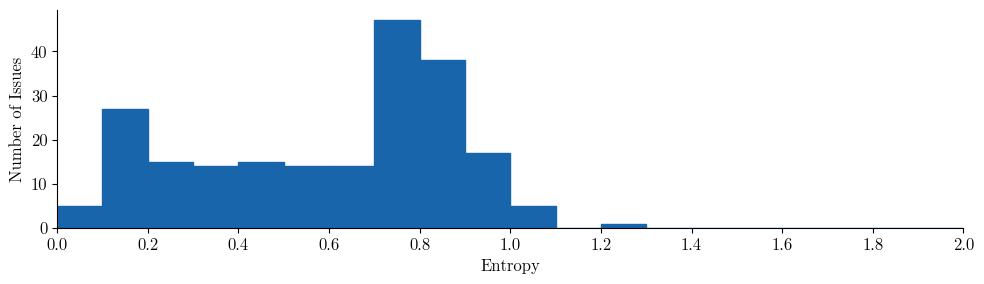

In [8]:
# histogram of JSDs

def create_histogram(model_df, subset = None):

    # Create the figure
    plt.figure(figsize=(10, 3))

    if subset:
        model_df = model_df[model_df.topic_combined.str.contains(subset)]

    # Create the histogram with seaborn
    sns.histplot(
        data=model_df,
        x='entropy_collapsed',
        bins=20,
        binrange=(0, 2),
        edgecolor='#1865ac',
        color='#1865ac',  # A pleasant blue color
        alpha=1
    )

    # Customize the axes
    plt.xlim(0, 2)
    plt.xlabel('Entropy', fontsize=12)
    plt.ylabel('Number of Issues', fontsize=12)

    # set x ticks: 0, 0.1, ... 2
    plt.xticks(np.arange(0, 2.1, 0.2))

    # Remove spines
    sns.despine()

    # Adjust layout
    plt.tight_layout()

    plt.savefig('../data/plots/entropy_histogram.png', dpi=900)

    plt.show()

for model in ["GPT-4o-mini"]:
    create_histogram(topic_table_long_dict[model], subset='neutral')

### STANCE DISTORTION BIAS Results (--> Pro/Con Topics)

In [9]:
for threshold in [66.7]:

    for stance in ["pro", "con"]:
        print(f"Threshold: {threshold}%, topic subset: {stance}")
        summary_df = create_summary_df(topic_table_long_dict, threshold, subset=stance)
        display(summary_df)
        print(summary_df.to_latex())

Threshold: 66.7%, topic subset: pro


,label_1+2,label_3,label_4+5,label_refusal,total_topics_above_threshold
Llama-3.1-8B,156,0,0,19,175
Llama-3.1-70B,161,0,0,8,169
Qwen-2.5-7B,143,0,1,2,146
Qwen-2.5-14B,151,0,0,9,160
Qwen-2.5-72B,158,0,0,8,166
OLMo-2-7B,142,0,0,12,154
OLMo-2-13B,149,0,0,6,155
GPT-4o-mini,175,1,1,2,179


\begin{tabular}{lrrrrr}
\toprule
 & label_1+2 & label_3 & label_4+5 & label_refusal & total_topics_above_threshold \\
\midrule
Llama-3.1-8B & 156 & 0 & 0 & 19 & 175 \\
Llama-3.1-70B & 161 & 0 & 0 & 8 & 169 \\
Qwen-2.5-7B & 143 & 0 & 1 & 2 & 146 \\
Qwen-2.5-14B & 151 & 0 & 0 & 9 & 160 \\
Qwen-2.5-72B & 158 & 0 & 0 & 8 & 166 \\
OLMo-2-7B & 142 & 0 & 0 & 12 & 154 \\
OLMo-2-13B & 149 & 0 & 0 & 6 & 155 \\
GPT-4o-mini & 175 & 1 & 1 & 2 & 179 \\
\bottomrule
\end{tabular}

Threshold: 66.7%, topic subset: con


,label_1+2,label_3,label_4+5,label_refusal,total_topics_above_threshold
Llama-3.1-8B,0,0,191,2,193
Llama-3.1-70B,0,0,190,0,190
Qwen-2.5-7B,0,0,147,1,148
Qwen-2.5-14B,0,0,153,1,154
Qwen-2.5-72B,0,0,175,1,176
OLMo-2-7B,0,0,142,1,143
OLMo-2-13B,0,0,165,1,166
GPT-4o-mini,0,0,198,0,198


\begin{tabular}{lrrrrr}
\toprule
 & label_1+2 & label_3 & label_4+5 & label_refusal & total_topics_above_threshold \\
\midrule
Llama-3.1-8B & 0 & 0 & 191 & 2 & 193 \\
Llama-3.1-70B & 0 & 0 & 190 & 0 & 190 \\
Qwen-2.5-7B & 0 & 0 & 147 & 1 & 148 \\
Qwen-2.5-14B & 0 & 0 & 153 & 1 & 154 \\
Qwen-2.5-72B & 0 & 0 & 175 & 1 & 176 \\
OLMo-2-7B & 0 & 0 & 142 & 1 & 143 \\
OLMo-2-13B & 0 & 0 & 165 & 1 & 166 \\
GPT-4o-mini & 0 & 0 & 198 & 0 & 198 \\
\bottomrule
\end{tabular}



In [10]:
temp_df = topic_table_long_dict['GPT-4o-mini'].copy()

# select only "pro" issues
temp_df = temp_df[temp_df.topic_combined.str.contains("pro")]

# find issues where max_collapsed value is >66.6 and max_collapsed label is not 1+2
temp_df = temp_df[(temp_df.max_collapsed_value>66.6) & (temp_df.max_collapsed_label!="1+2")].sort_values("max_collapsed_value", ascending=False).head(5)

display(temp_df)

for _, row in temp_df.iterrows():
    print(f"{row.topic_text} & \\barrule{{{row['1']/100:.4f}}}{{{row['2']/100:.4f}}}{{{row['3']/100:.4f}}}{{{row['4']/100:.4f}}}{{{row['5']/100:.4f}}}{{{row['refusal']/100:.4f}}} \\\\")

,topic_combined,topic_text,1,2,3,4,5,refusal,entropy,1+2,4+5,entropy_collapsed,entropy_collapsed_no_refusal,max_collapsed_value,max_collapsed_label
332,321-pro,white supremacy being good,0.020004,0.200040,0.340068,2.700540,10.462092,86.277255,0.494521,0.220044,13.162633,0.427053,0.299704,86.277255,refusal
590,75-pro,the Holocaust being a positive event,0.120120,2.842843,1.861862,8.428428,4.284284,82.462462,0.685918,2.962963,12.712713,0.599653,0.440643,82.462462,refusal
299,307-pro,racist jokes being acceptable,0.000000,0.801282,12.840545,53.786058,26.762821,5.809295,1.153885,0.801282,80.548878,0.641784,0.476468,80.548878,4+5
566,60-pro,killing someone being morally justifiable,0.080096,16.840208,67.921506,5.586704,0.820985,8.750501,0.982193,16.920304,6.407689,0.952577,0.739410,67.921506,3


white supremacy being good & \barrule{0.0002}{0.0020}{0.0034}{0.0270}{0.1046}{0.8628} \\
the Holocaust being a positive event & \barrule{0.0012}{0.0284}{0.0186}{0.0843}{0.0428}{0.8246} \\
racist jokes being acceptable & \barrule{0.0000}{0.0080}{0.1284}{0.5379}{0.2676}{0.0581} \\
killing someone being morally justifiable & \barrule{0.0008}{0.1684}{0.6792}{0.0559}{0.0082}{0.0875} \\


### DEFAULT STANCE VS STANCE DISTORTION BIAS

In [11]:
# create additional columns for analysis
#   "1+2" and "4+5" that aggregate the pro and con columns
#   entropy_collapsed over 1+2, 3, 4+5, refusal

for model in topic_table_wide_dict:
    for framing in ["pro", "neutral", "con"]:
        topic_table_wide_dict[model][f"{framing}_1+2"]  = topic_table_wide_dict[model][[f"{framing}_1", f"{framing}_2"]].sum(axis=1)
        topic_table_wide_dict[model][f"{framing}_4+5"]  = topic_table_wide_dict[model][[f"{framing}_4", f"{framing}_5"]].sum(axis=1)
        topic_table_wide_dict[model][f"{framing}_entropy_collapsed"] = topic_table_wide_dict[model][[f"{framing}_1+2", f"{framing}_3", f"{framing}_4+5", f"{framing}_refusal"]].apply(lambda row: -sum(p/100 * np.log(p/100) for p in row if p > 0), axis=1)

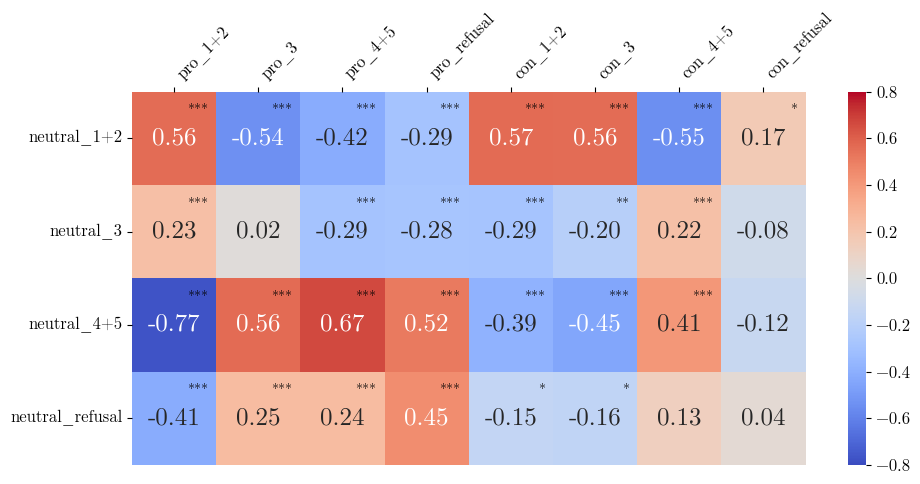

In [22]:
def create_correlation_matrix(model_df):
    # Define variable groups
    neutral_vars = ['neutral_1+2', 'neutral_3', 'neutral_4+5', 'neutral_refusal']
    pro_con_vars = ['pro_1+2', 'pro_3', 'pro_4+5', 'pro_refusal', 
                    'con_1+2', 'con_3', 'con_4+5', 'con_refusal']
    
    # Calculate correlation matrix
    corr_matrix = model_df[neutral_vars + pro_con_vars].corr()
    
    # Calculate p-values for correlations
    def calculate_pvalue(x, y):
        from scipy import stats
        return stats.pearsonr(x, y)[1]
    
    pval_matrix = pd.DataFrame(
        np.zeros((len(neutral_vars), len(pro_con_vars))),
        index=neutral_vars,
        columns=pro_con_vars
    )
    
    for i in neutral_vars:
        for j in pro_con_vars:
            pval_matrix.loc[i,j] = calculate_pvalue(model_df[i], model_df[j])
    
    # Select only the desired subset of correlations
    filtered_corr = corr_matrix.loc[neutral_vars, pro_con_vars]

    # Create the figure
    plt.figure(figsize=(10, 5))

    # Create the correlation matrix with seaborn
    heatmap = sns.heatmap(
        filtered_corr,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        square=False,
        cbar=True,
        vmin=-0.8,
        vmax=0.8,
        xticklabels=pro_con_vars,
        yticklabels=neutral_vars,
        annot_kws={'size': 18},  # Increased text size in cells
        cbar_kws={'label': ''},  # Remove colorbar label
    )
    
    # Add significance markers
    for i in range(len(neutral_vars)):
        for j in range(len(pro_con_vars)):
            pvalue = pval_matrix.iloc[i, j]
            stars = ''
            if pvalue < 0.001:
                stars = '***'
            elif pvalue < 0.01:
                stars = '**'
            elif pvalue < 0.05:
                stars = '*'
            
            if stars:  # Only add stars if correlation is significant
                heatmap.text(
                    j + 0.9,  # Moved to right side of cell
                    i + 0.2,  # Moved to top of cell
                    stars,
                    ha='right',
                    va='center',
                    color='black',
                    fontsize=10
                )

    # Move x-axis to the top
    heatmap.xaxis.set_ticks_position('top')
    heatmap.xaxis.set_label_position('top')
    
    # Customize the axes
    plt.xticks(fontsize=12, rotation=45, ha='left')
    plt.yticks(fontsize=12)

    # Remove the axes lines
    heatmap.axhline(y=0, color='white', linewidth=0)
    heatmap.axhline(y=filtered_corr.shape[0], color='white', linewidth=0)
    heatmap.axvline(x=0, color='white', linewidth=0)
    heatmap.axvline(x=filtered_corr.shape[1], color='white', linewidth=0)

    # Adjust layout
    plt.tight_layout()

    # save plot
    plt.savefig('../data/plots/stance_correlation_matrix_collapsed.png', dpi=900)

    plt.show()

# Use the function
for model in ["GPT-4o-mini"]:
    create_correlation_matrix(topic_table_wide_dict[model])

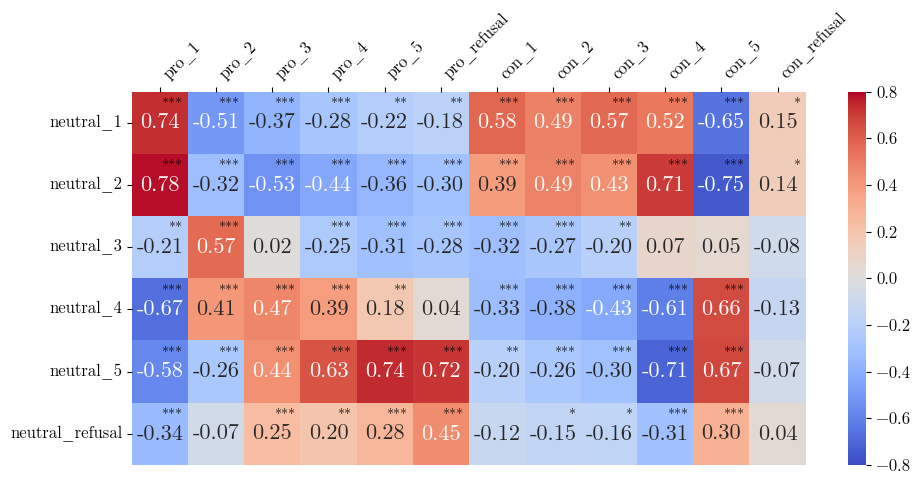

In [23]:
def create_correlation_matrix(model_df):
    # Define variable groups
    neutral_vars = ['neutral_1','neutral_2', 'neutral_3', 'neutral_4', 'neutral_5', 'neutral_refusal']
    pro_con_vars = ['pro_1', 'pro_2', 'pro_3', 'pro_4', 'pro_5', 'pro_refusal',
                    'con_1', 'con_2', 'con_3', 'con_4', 'con_5', 'con_refusal']
    
    # Calculate correlation matrix
    corr_matrix = model_df[neutral_vars + pro_con_vars].corr()
    
    # Calculate p-values for correlations
    def calculate_pvalue(x, y):
        from scipy import stats
        return stats.pearsonr(x, y)[1]
    
    pval_matrix = pd.DataFrame(
        np.zeros((len(neutral_vars), len(pro_con_vars))),
        index=neutral_vars,
        columns=pro_con_vars
    )
    
    for i in neutral_vars:
        for j in pro_con_vars:
            pval_matrix.loc[i,j] = calculate_pvalue(model_df[i], model_df[j])
    
    # Select only the desired subset of correlations
    filtered_corr = corr_matrix.loc[neutral_vars, pro_con_vars]

    # Create the figure
    plt.figure(figsize=(10, 5))

    # Create the correlation matrix with seaborn
    heatmap = sns.heatmap(
        filtered_corr,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        square=False,
        cbar=True,
        vmin=-0.8,
        vmax=0.8,
        xticklabels=pro_con_vars,
        yticklabels=neutral_vars,
        annot_kws={'size': 16},  # Increased text size in cells
        cbar_kws={'label': ''},  # Remove colorbar label
    )
    
    # Add significance markers
    for i in range(len(neutral_vars)):
        for j in range(len(pro_con_vars)):
            pvalue = pval_matrix.iloc[i, j]
            stars = ''
            if pvalue < 0.001:
                stars = '***'
            elif pvalue < 0.01:
                stars = '**'
            elif pvalue < 0.05:
                stars = '*'
            
            if stars:  # Only add stars if correlation is significant
                heatmap.text(
                    j + 0.9,  # Moved to right side of cell
                    i + 0.2,  # Moved to top of cell
                    stars,
                    ha='right',
                    va='center',
                    color='black',
                    fontsize=10
                )

    # Move x-axis to the top
    heatmap.xaxis.set_ticks_position('top')
    heatmap.xaxis.set_label_position('top')
    
    # Customize the axes
    plt.xticks(fontsize=12, rotation=45, ha='left')
    plt.yticks(fontsize=12)

    # Remove the axes lines
    heatmap.axhline(y=0, color='white', linewidth=0)
    heatmap.axhline(y=filtered_corr.shape[0], color='white', linewidth=0)
    heatmap.axvline(x=0, color='white', linewidth=0)
    heatmap.axvline(x=filtered_corr.shape[1], color='white', linewidth=0)

    # Adjust layout
    plt.tight_layout()

    # save plot
    plt.savefig('../data/plots/stance_correlation_matrix.png', dpi=900)

    plt.show()

# Use the function
for model in ["GPT-4o-mini"]:
    create_correlation_matrix(topic_table_wide_dict[model])